<a href="https://colab.research.google.com/github/marianasod/xp_projeto_pratico/blob/main/Modelos_previsao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Bibliotecas

In [ ]:
pip install pmdarima autots tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 851.0/851.0 kB 37.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from autots import AutoTS
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

Funções

In [ ]:
def model_auto_arima(train_base, test_base, var_preco, var_data, var_exogenous, use_exogenous):

    if use_exogenous:
      model = auto_arima(
            train_base[var_preco],
            exogenous=train_base[var_exogenous],
            seasonal=True,  # Define como True se houver sazonalidade
            d=None,
            D=None,
            max_d=2,
            max_D=2,
            max_p=5,
            max_q=5,
            max_P=5,
            max_Q=5,
            trace=True,
            error_action='ignore',
            suppress_warnings=True)
    else:
      model = auto_arima(
            train_base[var_preco],
            seasonal=True,  # Define como True se houver sazonalidade
            d=None,
            D=None,
            max_d=2,
            max_D=2,
            max_p=5,
            max_q=5,
            max_P=5,
            max_Q=5,
            trace=True,
            error_action='ignore',
            suppress_warnings=True)
    forecast = model.predict(n_periods=len(test_base))

    return [model, forecast]

def fit_autots(train_base, test_base, var_preco, var_data, var_exogenous, use_exogenous):

    model = AutoTS(
            forecast_length=len(test_base),
            frequency='D',
            ensemble=None,  # Pode usar 'simple', 'sophisticated', ou deixar como None para o padrão
            prediction_interval=0.95,
            model_list="superfast")

    if use_exogenous:
          model.fit(
              train_base[var_preco],
              future_regressor=train_base[var_exogenous])
    else:
          model.fit(train_base[var_preco])

    forecast = model.predict().forecast
    forecast = forecast.values.flatten()

    return [model, forecast]

def apply_lstm_model(train, test, var_preco, var_exogenous, use_exogenous, epochs=50, batch_size=32):
    """
    Aplica um modelo LSTM a uma série temporal já dividida em treino e teste.
    :param train: Conjunto de treino para as entradas (sequências de características).
    :param X_test: Conjunto de teste para as entradas (sequências de características).
    :param epochs: Número de épocas para o treinamento do modelo.
    :param batch_size: Tamanho do lote para o treinamento do modelo.
    :return: Previsões do modelo, valores reais de teste, e o modelo treinado.
    """
    # Inicializar o MinMaxScaler para escalar as entradas e saídas
    scaler_X = MinMaxScaler(feature_range=(0, 1))
    scaler_y = MinMaxScaler(feature_range=(0, 1))
    X_train = train.drop(columns = [var_preco, var_exogenous]).values
    y_train = train[var_preco].values
    X_test = test.drop(columns = [var_preco, var_exogenous]).values
    y_test = test[var_preco].values
    # Ajustar o escalador e transformar os dados de treino
    X_train_scaled = scaler_X.fit_transform(X_train)
    y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
    X_test_scaled = scaler_X.transform(X_test)
    y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

    # Codificar a variável exógena categórica
    if use_exogenous:
      encoder = OneHotEncoder(sparse=False)
      exog_train_encoded = encoder.fit_transform(train[var_exogenous].values.reshape(-1, 1))
      exog_test_encoded = encoder.transform(test[var_exogenous].values.reshape(-1, 1))
      # Concatenar a variável exógena com os dados de entrada
      X_train_final = np.concatenate((X_train_scaled, exog_train_encoded), axis=1)
      X_test_final = np.concatenate((X_test_scaled, exog_test_encoded), axis=1)
    else:
      X_train_final = X_train_scaled
      X_test_final = X_test_scaled

    n_features = X_train_final.shape[1]
    X_train_final = X_train_final.reshape((X_train_final.shape[0], X_train_final.shape[1], 1))
    # Construir o modelo LSTM
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(X_train_final.shape[1], X_train_final.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(25))
    model.add(Dense(1))
    # Compilar o modelo
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train_final, y_train_scaled, epochs=epochs, batch_size=batch_size, verbose=1)
    # Fazer previsões
    forecast = model.predict(X_test_final)
    predictions = scaler_y.inverse_transform(forecast)

    return [model, predictions.flatten()]

def model_adjust_time_split(dataframe, var_preco, var_sentimento, var_date, split_object, var_exogenous, use_exogenous, model_type):
    if not pd.api.types.is_datetime64_any_dtype(dataframe.index):
        dataframe[var_date] = pd.to_datetime(dataframe[var_date])
        dataframe.set_index(var_date, inplace=True)
    dataframe.sort_index(inplace=True)
    mse_scores = []
    accuracy_scores = []
    results = []

    def classify_price_movement(prices):
        return np.sign(prices.diff().fillna(0))
    for fold, (train_index, test_index) in enumerate(tscv.split(dataframe)):
        train, test = dataframe.iloc[train_index], dataframe.iloc[test_index]
        if model_type == 'arima':
           model, forecast = model_auto_arima(train, test, var_preco, var_date, var_exogenous, use_exogenous)
        if model_type == 'autots':
           model, forecast = fit_autots(train, test, var_preco, var_date, var_exogenous, use_exogenous)
        if model_type == 'lstm':
           model, forecast = apply_lstm_model(train, test, var_preco, var_exogenous, use_exogenous, epochs=50, batch_size=32)

        # Avaliação do Modelo
        mse = mean_squared_error(test[var_preco], forecast)
        mse_scores.append(mse)
         # Classificando movimentos reais e previstos
        real_movement = classify_price_movement(test[var_preco])
        predicted_movement = classify_price_movement(pd.Series(forecast, index=test.index))
        # Calcular acurácia de previsão
        accuracy = accuracy_score(real_movement, predicted_movement)
        accuracy_scores.append(accuracy)

        print(f'Fold {fold+1}: Acurácia = {accuracy}, MSE = {mse}')
        results.append({ 'fold': fold + 1, 'train': train, 'test': test, 'forecast': forecast, 'real_movement': real_movement,
            'predicted_movement': predicted_movement, 'mse': mse, 'accuracy': accuracy})

    # Calcular e retornar as médias das métricas
    mean_accuracy = np.mean(accuracy_scores)
    mean_mse = np.mean(mse_scores)
    print(f'\nMédia das Acurácias: {mean_accuracy}')
    print(f'Média dos MSEs: {mean_mse}')
    print(f'Média dos Mean Squared Errors: {np.mean(mse_scores)}')

    return results

def visualize_model_results(results, var_preco):
    for result in results:
        fold = result['fold']
        test = result['test']
        forecast = result['forecast']
        real_movement = result['real_movement']
        predicted_movement = result['predicted_movement']

        # Visualização dos resultados
        plt.figure(figsize=(11, 6))

        # Gráfico de Preços Reais vs Preços Previstos
        plt.subplot(2, 1, 1)
        plt.plot(test.index, test[var_preco], label='Preço Real', color='blue')
        plt.plot(test.index, forecast, label='Preço Previsto', color='orange')
        plt.title(f'Fold {fold}: Preço Real vs Preço Previsto')
        plt.xlabel('Data')
        plt.ylabel('Preço')
        plt.legend()

        # Gráfico de Classificação dos Movimentos de Preço
        plt.subplot(2, 1, 2)
        plt.plot(test.index, real_movement, label='Movimento Real', marker='o', linestyle='-', color='blue')
        plt.plot(test.index, predicted_movement, label='Movimento Previsto', marker='x', linestyle='-', color='orange')
        plt.title(f'Fold {fold}: Movimento de Preço Real vs Previsto')
        plt.xlabel('Data')
        plt.ylabel('Movimento de Preço')
        plt.legend()

        plt.tight_layout()
        plt.show()

def transform_to_weekly(df, date_col='Date', value_col='Price', sentiment_col = 'sentiment', agg_func='mean'):
    """
    Transforma um DataFrame de preço diário em um DataFrame semanal.
    """
    # Certificar-se de que a coluna de datas está no formato datetime e definir como índice
    df[date_col] = pd.to_datetime(df[date_col])
    df.set_index(date_col, inplace=True)

    # Resample para frequência semanal e aplicar a função de agregação
    if agg_func == 'mean':
        weekly_df = df[value_col].resample('W').mean()
    elif agg_func == 'median':
        weekly_df = df[value_col].resample('W').median()
    elif agg_func == 'sum':
        weekly_df = df[value_col].resample('W').sum()
    elif agg_func == 'max':
        weekly_df = df[value_col].resample('W').max()
    elif agg_func == 'min':
        weekly_df = df[value_col].resample('W').min()
    else:
        raise ValueError("Função de agregação não suportada. Use 'mean', 'sum', 'max', ou 'min'.")

    weekly_df_sentiment = df.resample('W')[sentiment_col].agg(lambda x: x.mode().iloc[0])

    # Ensure both weekly_df and weekly_df_sentiment are DataFrames before merging
    if not isinstance(weekly_df, pd.DataFrame):
        weekly_df = weekly_df.to_frame()  # Convert to DataFrame if it's a Series
    if not isinstance(weekly_df_sentiment, pd.DataFrame):
        weekly_df_sentiment = weekly_df_sentiment.to_frame()

    # Reset the index to return the date column as a normal column
    weekly_df.reset_index(inplace=True)  # Add drop=True to avoid old index becoming a column
    weekly_df_sentiment.reset_index(inplace=True)

    # Merge price and sentiment data
    weekly_df = pd.merge(weekly_df, weekly_df_sentiment, on='Data')

    return weekly_df

Leitura das bases

In [ ]:
precos_sentimentos = pd.read_excel("/content/base_sentimentos_noticias.xlsx")

In [ ]:
# data_ref = '2023-11-01'
# precos_sentimentos = precos_sentimentos[precos_sentimentos.Data >= data_ref]

mapping = {
    'positive': 1,
    'negative': -1,
    'neutral': 0
}

precos_sentimentos['sentiment_mapped'] = precos_sentimentos['sentimento_mais_frequente'].map(mapping)

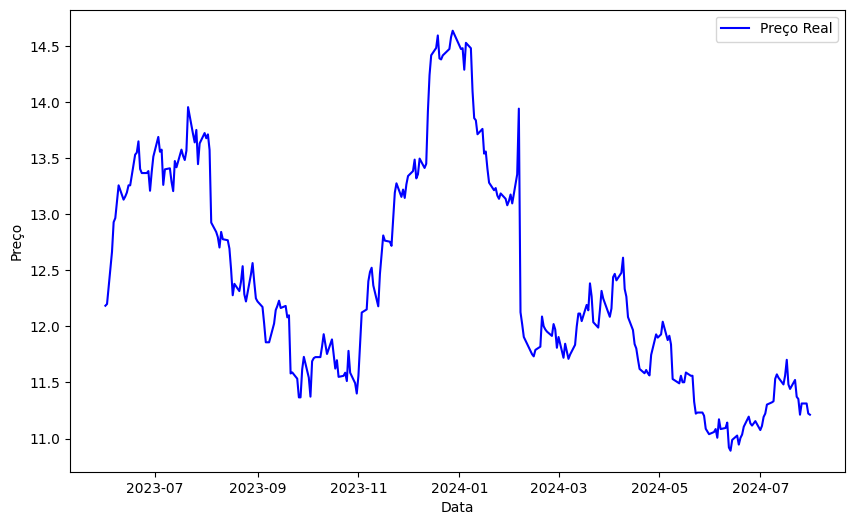

In [ ]:
 # Gráfico de Preços Reais vs Preços Previstos
plt.figure(figsize=(10, 6))
plt.plot(precos_sentimentos["Data"], precos_sentimentos['Preco_close'], label='Preço Real', color='blue')
plt.xlabel('Data')
plt.ylabel('Preço')
plt.legend()

Transformando os dados em semanais

In [ ]:
# Suponha que df seja o DataFrame contendo colunas 'Date' e 'Price'
weekly_df = transform_to_weekly(
    precos_sentimentos[['Data',"Preco_close", "sentiment_mapped"]], date_col='Data', value_col='Preco_close', sentiment_col = "sentiment_mapped" , agg_func='median')

<ipython-input-5-585f1c54edf2>:220: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[date_col] = pd.to_datetime(df[date_col])


In [ ]:
# Normalizando os dados de preço e sentimento
scaler_price = StandardScaler()
weekly_df['Preco_close_transf'] = scaler_price.fit_transform(weekly_df[['Preco_close']])
weekly_df['Preco_close_diff'] = weekly_df['Preco_close'].diff(periods=1).fillna(0)

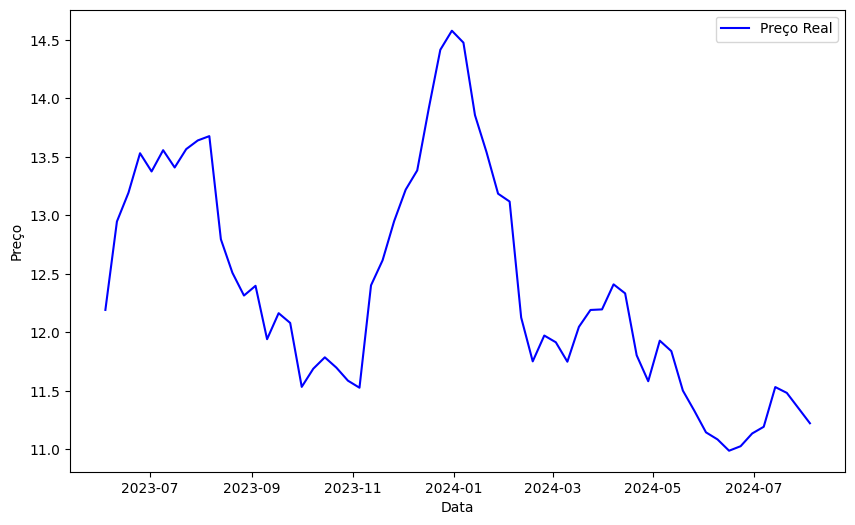

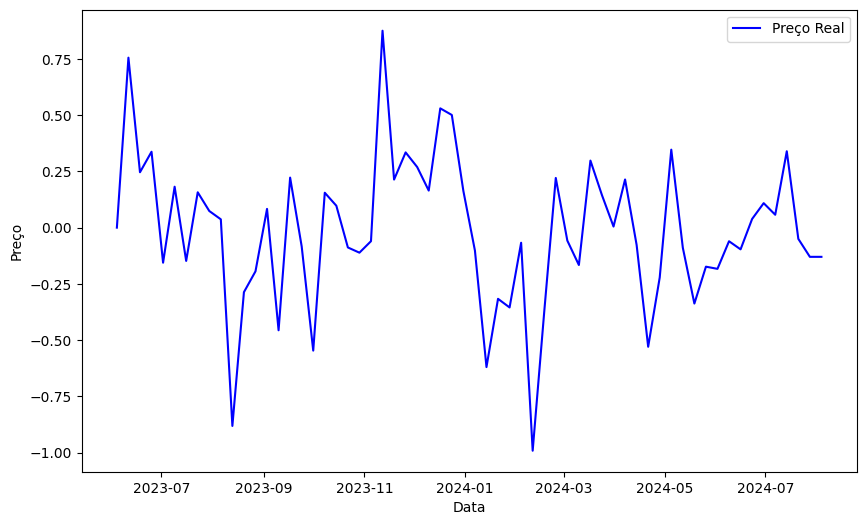

In [ ]:
 # Gráfico de Preços Reais vs Preços Previstos
plt.figure(figsize=(10, 6))
plt.plot(weekly_df["Data"], weekly_df['Preco_close'], label='Preço Real', color='blue')
plt.xlabel('Data')
plt.ylabel('Preço')
plt.legend()

 # Gráfico de Preços Reais vs Preços Previstos
plt.figure(figsize=(10, 6))
plt.plot(weekly_df["Data"], weekly_df['Preco_close_diff'], label='Preço Real', color='blue')
plt.xlabel('Data')
plt.ylabel('Preço')
plt.legend()

In [ ]:
# Configurando a validação cruzada com 5 divisões
tscv = TimeSeriesSplit(n_splits=6)
model_type = 'lstm'
var_exogenous = 'sentiment_mapped'
use_exogenous = False
#model_type ='arima'
results = model_adjust_time_split(weekly_df, 'Preco_close', "sentiment_mapped", 'Data', tscv, var_exogenous, use_exogenous, model_type)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 0.4775
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 0.4432
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.4200
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.4002
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.3801
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.3620
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.3400
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.3157
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.2772
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.2621
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.2518
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.2336
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.2085
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.1880
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.1633
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - loss: 0.3738
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.3545
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.3404
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.3207
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.3038
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.2909
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.2666
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.2509
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.2365
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.2210
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.2026
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.1832
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.1713
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.1556
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.1411
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.2511
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.2379
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.2197
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.2097
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1964
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.1803
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.1635
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.1567
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.1434
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.1319
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.1204
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.1068
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0990
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0884
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0730
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/st

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.2725
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2381
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2120
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1948 
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1716
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1422
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1216 
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1036 
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0785 
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0653
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0585 
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0496 
Epoch 13/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0496 
Epoch 14/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0491
Epoch 15/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0486
Epoch 16/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.2063
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1886
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1830
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1481
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1499
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1073
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0968
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0736
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0710 
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0561
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0489
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0553
Epoch 13/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0522
Epoch 14/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0612
Epoch 15/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0609
Epoch 16/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.2203
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2268
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1902 
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1827 
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1417 
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1223
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1194 
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0847
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0669 
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0536
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0480
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0379
Epoch 13/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0452
Epoch 14/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0539
Epoch 15/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0473 
Epoch 16/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s

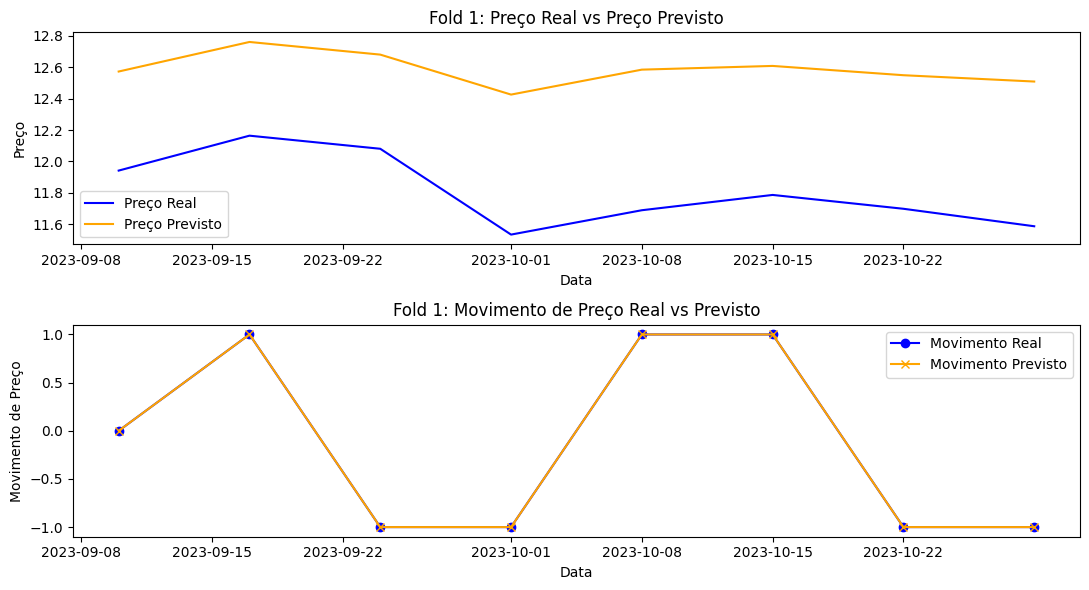

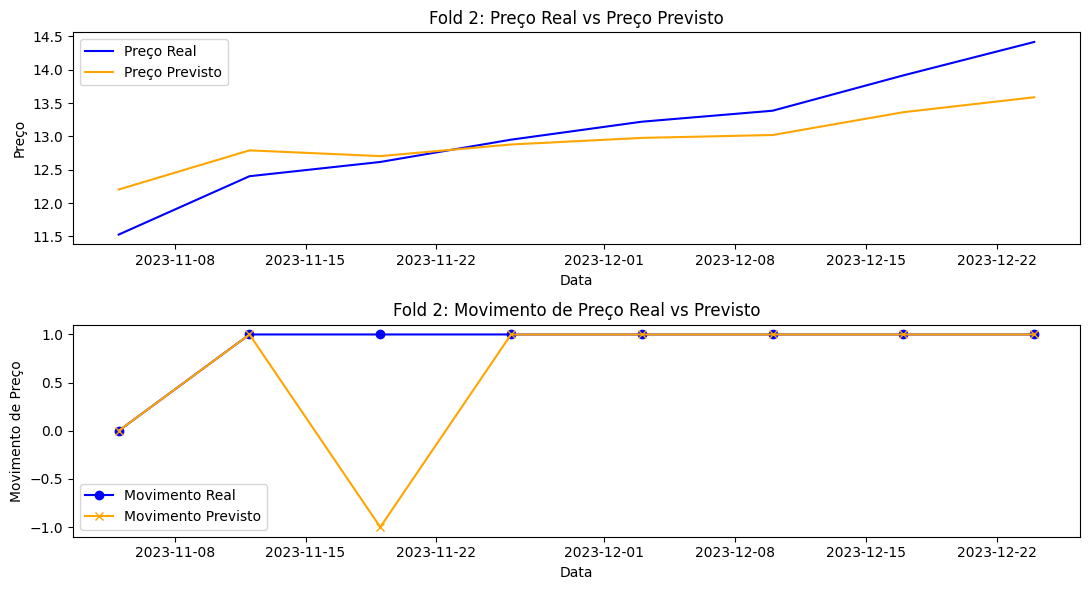

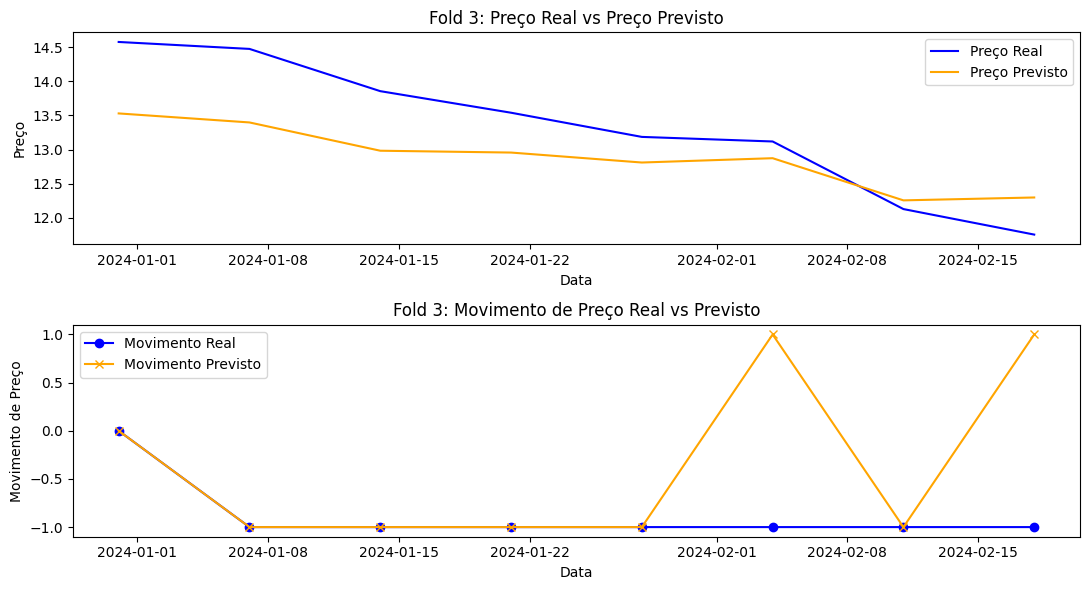

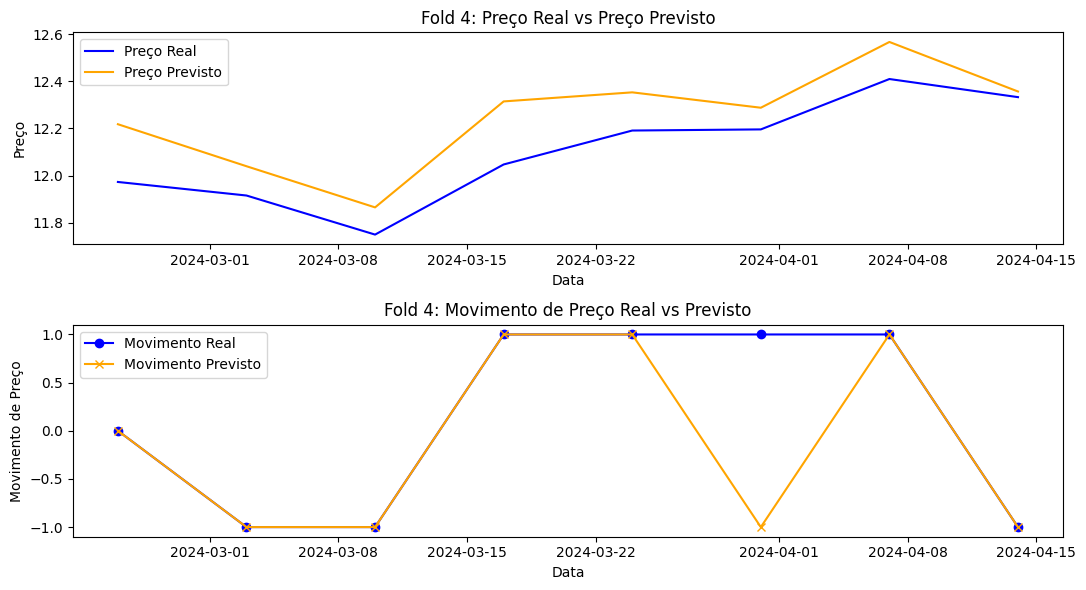

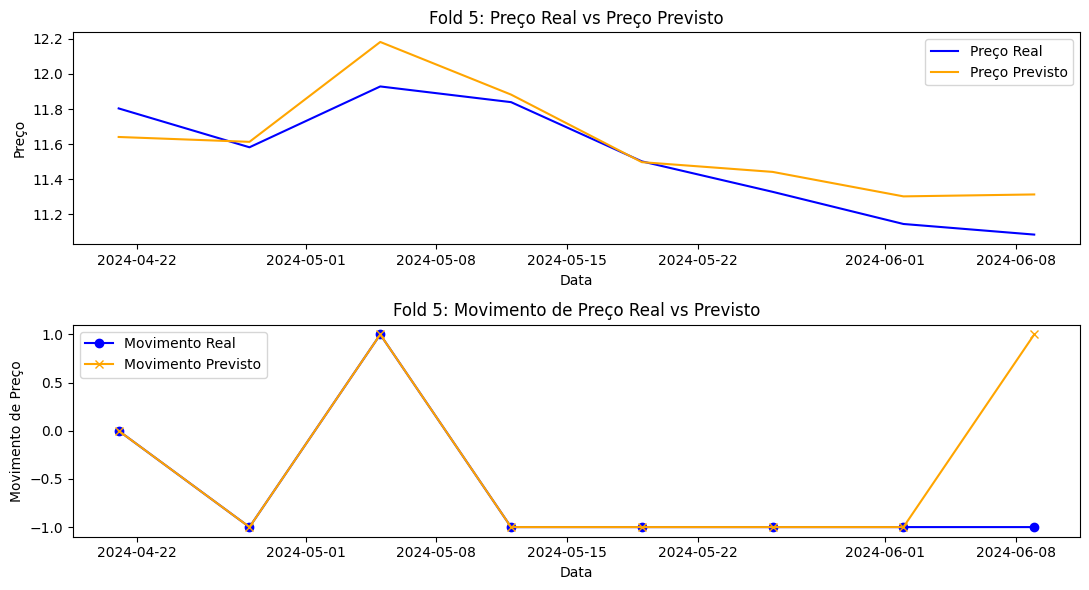

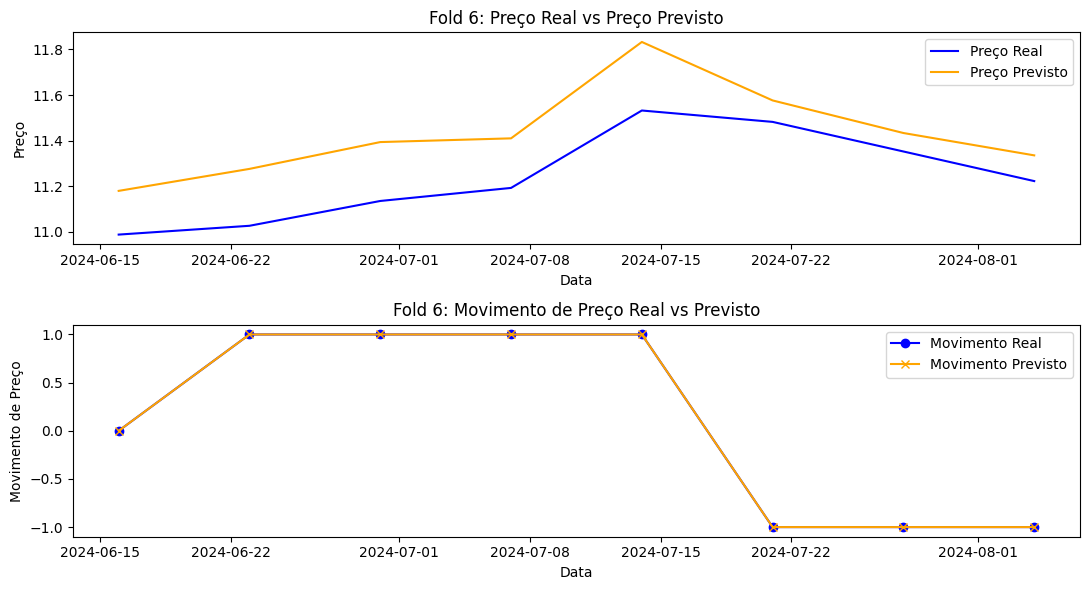

In [ ]:
visualize_model_results(results, 'Preco_close')